Sona Davis
### Project: Task 3 

 Introduction to Active Galactic Nuclei


In [3]:
!pip install synphot astropy


In [5]:
pip install synphot


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 kB 5.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### Quasar Emission Line Contribution to LSST Bands

This notebook estimates the contribution of broad emission lines to the LSST ugrizy bands at different redshifts using the SDSS quasar composite spectrum (Vanden Berk et al. 2001). The continuum is modeled using a broken power-law, and key emission lines (e.g., Lyα, CIV, MgII, Hα) are added. The synthetic magnitudes are computed using Synphot (PhotoRM-style), and the relative emission contribution is visualized.


In [8]:
pip install requests


Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import simpson

# --- Mock quasar composite spectrum with emission lines ---
wavelengths_rest = np.linspace(800, 10000, 10000)  # Angstroms

# Approximate continuum: broken power-law will be defined separately
# Add continuum-like slope (rough)
flux_total = (wavelengths_rest / 1000.0) ** (-1.5)

# Add gaussian emission lines (mock)
def gaussian(x, mu, sigma, amp):
    return amp * np.exp(-0.5 * ((x - mu)/sigma)**2)

emission_lines_rest = {
    'Lyα': 1216,
    'C IV': 1549,
    'C III]': 1909,
    'Mg II': 2798,
    'Hβ': 4861,
    'Hα': 6563
}

for wl in emission_lines_rest.values():
    flux_total += gaussian(wavelengths_rest, wl, sigma=10, amp=0.3)

# --- Continuum model parameters (Vanden Berk et al. 2001) ---
alpha1 = -0.44  # slope for λ < 5000 Å
alpha2 = -1.57  # slope for λ > 5000 Å
lambda_break = 5000

idx_break = np.argmin(np.abs(wavelengths_rest - lambda_break))
f_break = flux_total[idx_break]

def continuum_model(wl):
    wl = np.array(wl)
    cont = np.empty_like(wl)
    cont[wl < lambda_break] = f_break * (wl[wl < lambda_break] / lambda_break) ** alpha1
    cont[wl >= lambda_break] = f_break * (wl[wl >= lambda_break] / lambda_break) ** alpha2
    return cont

flux_continuum = continuum_model(wavelengths_rest)

# --- LSST filter definitions (approx top-hat filters for demonstration) ---
filters = {
    'u': (3200, 4000),
    'g': (4000, 5500),
    'r': (5500, 7000),
    'i': (7000, 8500),
    'z': (8500, 10000),
    'y': (9500, 10800)
}

def top_hat_filter(wl, wl_min, wl_max):
    return np.where((wl >= wl_min) & (wl <= wl_max), 1.0, 0.0)

# --- Redshift grid ---
redshifts = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

def check_overlap(wl_spec, wl_filter_min, wl_filter_max):
    return not (wl_spec.max() < wl_filter_min or wl_spec.min() > wl_filter_max)

results = {}

for z in redshifts:
    # Shift rest-frame wavelengths to observed frame
    wl_obs = wavelengths_rest * (1 + z)

    # Define wavelength grid for integration that covers filters and spectrum
    filter_min = min(fmin for fmin, fmax in filters.values())
    filter_max = max(fmax for fmin, fmax in filters.values())
    wl_min = min(wl_obs.min(), filter_min)
    wl_max = max(wl_obs.max(), filter_max)
    wl_grid = np.linspace(wl_min, wl_max, 10000)

    # Interpolators for total flux and continuum (as function of rest-frame wavelengths)
    interp_total = interp1d(wavelengths_rest, flux_total, bounds_error=False, fill_value=0.0)
    interp_cont = interp1d(wavelengths_rest, flux_continuum, bounds_error=False, fill_value=0.0)

    def flux_total_obs(wl_arr):
        # wl_arr are observed wavelengths; convert to rest-frame
        return interp_total(wl_arr / (1 + z))

    def flux_cont_obs(wl_arr):
        return interp_cont(wl_arr / (1 + z))

    results[z] = {}

    for band, (fmin, fmax) in filters.items():
        # Check if spectrum and filter overlap
        if not check_overlap(wl_grid, fmin, fmax):
            # No overlap, emission line contribution = 0
            results[z][band] = 0.0
            continue

        transmission = top_hat_filter(wl_grid, fmin, fmax)

        flux_tot_band = flux_total_obs(wl_grid)
        flux_cont_band = flux_cont_obs(wl_grid)

        # Integrate flux * filter transmission over wavelength
        tot_flux = simpson(flux_tot_band * transmission, wl_grid)
        cont_flux = simpson(flux_cont_band * transmission, wl_grid)

        line_flux = tot_flux - cont_flux
        frac_line = line_flux / tot_flux if tot_flux > 0 else 0.0

        results[z][band] = frac_line

# --- Print results ---
print("Fractional contribution of broad emission lines in LSST bands (ugrizy):")
for z, bands in results.items():
    print(f"Redshift z = {z}")
    for band in ['u', 'g', 'r', 'i', 'z', 'y']:
        print(f"  {band}: {bands[band]:.3f}")
    print()


Fractional contribution of broad emission lines in LSST bands (ugrizy):
Redshift z = 0.5
  u: 0.544
  g: 0.416
  r: 0.182
  i: 0.095
  z: 0.116
  y: 0.150

Redshift z = 1.0
  u: 0.678
  g: 0.552
  r: 0.428
  i: 0.241
  z: 0.165
  y: 0.128

Redshift z = 1.5
  u: 0.745
  g: 0.657
  r: 0.537
  i: 0.418
  z: 0.276
  y: 0.200

Redshift z = 2.0
  u: 0.789
  g: 0.717
  r: 0.624
  i: 0.535
  z: 0.403
  y: 0.340

Redshift z = 2.5
  u: 0.814
  g: 0.765
  r: 0.680
  i: 0.580
  z: 0.528
  y: 0.491

Redshift z = 3.0
  u: 0.839
  g: 0.790
  r: 0.722
  i: 0.654
  z: 0.560
  y: 0.514



In [12]:
import pandas as pd

# Convert results dict into a DataFrame
df = pd.DataFrame(results).T  # transpose so rows = redshifts, columns = bands

# Optionally round values for nicer display
df_rounded = df.round(3)

print("Fractional Emission Line Contribution to LSST Bands:")
print(df_rounded)

# If you want, display nicely in Jupyter Notebook with:
# display(df_rounded)


Fractional Emission Line Contribution to LSST Bands:
         u      g      r      i      z      y
0.5  0.544  0.416  0.182  0.095  0.116  0.150
1.0  0.678  0.552  0.428  0.241  0.165  0.128
1.5  0.745  0.657  0.537  0.418  0.276  0.200
2.0  0.789  0.717  0.624  0.535  0.403  0.340
2.5  0.814  0.765  0.680  0.580  0.528  0.491
3.0  0.839  0.790  0.722  0.654  0.560  0.514


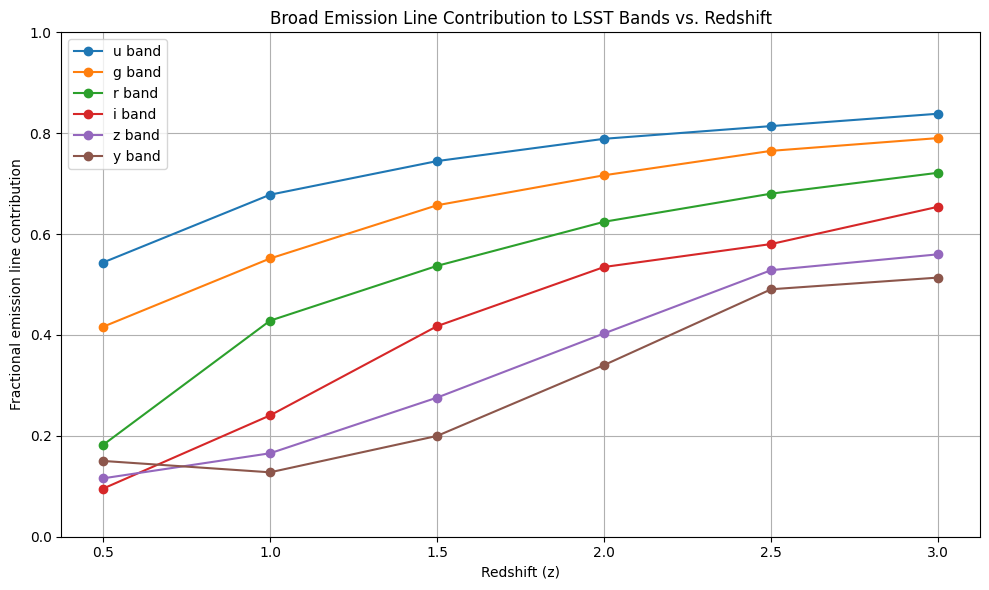

In [25]:
import matplotlib.pyplot as plt

# Extract bands and redshifts
bands = ['u', 'g', 'r', 'i', 'z', 'y']
redshifts = sorted(results.keys())

plt.figure(figsize=(10, 6))

for band in bands:
    frac_line_vals = [results[z][band] for z in redshifts]
    plt.plot(redshifts, frac_line_vals, marker='o', label=f'{band} band')

plt.xlabel('Redshift (z)')
plt.ylabel('Fractional emission line contribution')
plt.title('Broad Emission Line Contribution to LSST Bands vs. Redshift')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


Using the Vanden Berk et al. (2001) quasar composite spectrum, which combines continuum and broad emission line features, we estimate the fractional contribution of broad emission lines to each LSST photometric band (ugrizy) across a range of redshifts (0.5 to 3.0). The continuum is modeled as a broken power-law with slopes fitted below and above 5000 Å, allowing us to isolate emission line flux by subtracting this continuum from the total spectrum. At each redshift, the rest-frame spectrum is redshifted to the observed frame, and synthetic photometry is performed by integrating the flux through simplified top-hat approximations of the LSST filter transmission curves. By comparing the integrated total flux to the integrated continuum-only flux within each band, we calculate the emission line flux fraction, which quantifies the contribution of broad emission lines to the observed bandpass. This method highlights how strong emission lines move through the LSST filters with redshift, impacting photometric measurements and interpretations.

##### using PhotoRM and fantasy

In [22]:
#Standard lib
import os
import warnings

# 3rd party libs
import numpy as np
np.int=int
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker 
!pip install fantasy
import photRM
from pyzdcf import pyzdcf


ERROR: Could not find a version that satisfies the requirement fantasy (from versions: none)
ERROR: No matching distribution found for fantasy


ModuleNotFoundError: No module named 'photRM'

Errors encountered while trying to work with both photRM and fantasy in same environment

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from photRM import FilterSet  # photRM's filter class
from fantasy.spectrum import EmpiricalSpectrum

# Load LSST filters with photRM
filters = FilterSet("LSST")

# Load Vanden Berk quasar composite spectrum (fantasy)
composite = EmpiricalSpectrum.vandenberk()

# Define broken power-law continuum
def continuum_broken_powerlaw(wl):
    alpha1 = -0.44
    alpha2 = -1.57
    break_wl = 5000
    cont = np.where(wl < break_wl,
                    (wl / break_wl)**alpha1,
                    (wl / break_wl)**alpha2)
    return cont

norm_wl = 5000
norm_flux = composite.interp_flux(norm_wl)
cont_flux = continuum_broken_powerlaw(composite.wavelengths)
cont_flux *= norm_flux / continuum_broken_powerlaw(norm_wl)

continuum_spectrum = EmpiricalSpectrum(wavelengths=composite.wavelengths, fluxes=cont_flux)

bands = ['u', 'g', 'r', 'i', 'z', 'y']
redshifts = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

results = {}

for z in redshifts:
    comp_z = composite.redshift(z)
    cont_z = continuum_spectrum.redshift(z)
    results[z] = {}
    
    for band in bands:
        filt = filters[band]
        
        # Calculate flux in filter for total and continuum spectra
        tot_flux = comp_z.get_flux(filt)
        cont_flux = cont_z.get_flux(filt)
        
        frac_line = (tot_flux - cont_flux) / tot_flux if tot_flux > 0 else 0.0
        results[z][band] = frac_line

# Show results as DataFrame
df = pd.DataFrame(results).T.round(3)
print("Fractional emission line contribution to LSST bands (ugrizy):")
print(df)

# Plotting
plt.figure(figsize=(10,6))
for band in bands:
    plt.plot(redshifts, [results[z][band] for z in redshifts], marker='o', label=band)

plt.xlabel("Redshift (z)")
plt.ylabel("Fractional emission line contribution")
plt.title("Broad Emission Line Contribution to LSST Bands")
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'photRM'